In [13]:
import string
from bs4 import BeautifulSoup
from nltk.tokenize import word_tokenize
from collections import Counter
import datetime
import pandas as pd
import numpy as np
import umap
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from scipy import sparse
import matrix

In [43]:
#LatentDirichletAllocation
def get_terms(topic_number, corpus, component):
    component_for_topic = component[topic_number, :][0]
    corpus_weight_for_topic = zip(corpus, component_for_topic)
    return np.array(sorted(corpus_weight_for_topic, key=lambda x: x[1], reverse=True)[:30])[:, 0]


def get_top_terms_for_even_documents(svd, component, corpus):
    significant_topic_for_each_row = np.argmax(svd, axis=1).reshape((svd.shape[0], 1))
    return np.apply_along_axis(get_terms, 1, significant_topic_for_each_row, corpus, component)    

topic_count = 20

matrix_documents, terms = matrix.read_matrix()
origignal_matrix = matrix_documents.toarray()


from sklearn.decomposition import TruncatedSVD, LatentDirichletAllocation
lda = LatentDirichletAllocation(n_components=topic_count, random_state=0)
topics = lda.fit_transform(origignal_matrix)
components = lda.components_


top_terms = get_top_terms_for_even_documents(topics, components, terms)
embedding = TSNE(n_components=2, metric='cosine',random_state=5).fit_transform(topics)

print('end')

end


In [44]:
cluser_count = 20
kmeans = KMeans(n_clusters=cluser_count, random_state=3)
clusters = kmeans.fit_predict(embedding)

In [6]:
cluser_count = 10
from sklearn.cluster import AgglomerativeClustering
clusters = AgglomerativeClustering(n_clusters=cluser_count).fit_predict(embedding)

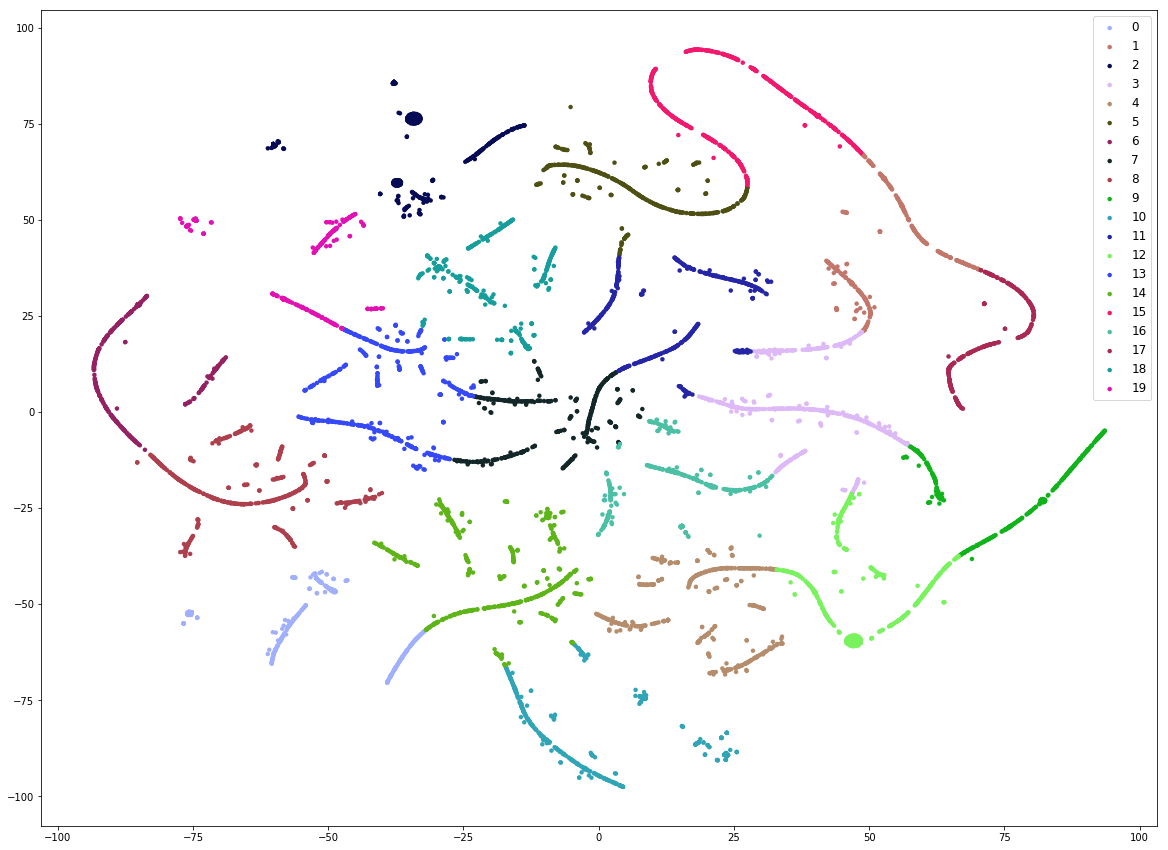

In [45]:
df = pd.DataFrame(clusters, columns=['cluster_n'])
df['Id'] = np.arange(len(df))
df['x'] = embedding[:, 0]
df['y'] = embedding[:, 1]

plt.figure(figsize=(20, 15))
group_by_cluster = df.groupby('cluster_n')
for name, group in group_by_cluster:
    c = np.array([np.random.rand(3,)]* len(group['Id']))
    plt.scatter(group['x'], group['y'],
                s=20,
                c=c,
                edgecolor='none',
                label=name)

plt.legend(fontsize=12)
plt.show()


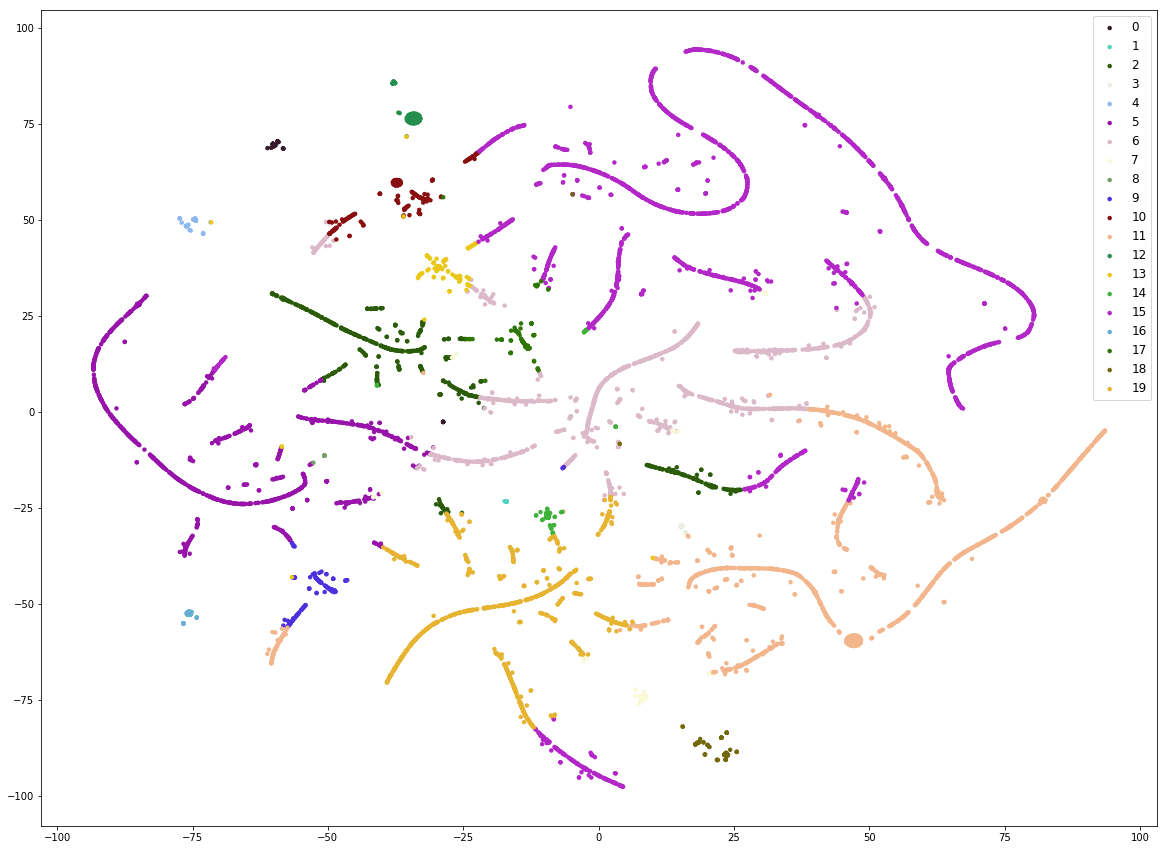

In [46]:
clusters_by_topics = np.argmax(topics, axis=1).reshape((topics.shape[0], 1))
df = pd.DataFrame(clusters_by_topics, columns=['cluster_n'])
df['Id'] = np.arange(len(df))
df['x'] = embedding[:, 0]
df['y'] = embedding[:, 1]

plt.figure(figsize=(20, 15))
group_by_cluster = df.groupby('cluster_n')
for name, group in group_by_cluster:        
    c = np.array([np.random.rand(3,)]* len(group['Id']))
    plt.scatter(group['x'], group['y'],
                s=20,
                c=c,
                edgecolor='none',
               label=name)
    
plt.legend(fontsize=12)

In [47]:
def print_topics(count_related_words, components, terms):
    for i, comp in enumerate(components):
        terms_comp = zip(terms, comp)
        sorted_terms = sorted(terms_comp, key=lambda x: x[1], reverse=True)[:count_related_words]
        topic = "Topic " + str(i) + ": "
        for sorted_term in sorted_terms:
            topic = topic + sorted_term[0] + ' '
        print()
        print(topic)

print_topics(20, components, terms )


Topic 0: forbes рунет школа ios европа входящая топ комфортный удалённый онлайн swift вводный английский версия менеджер objective математика крупный язык продажа 

Topic 1: нейронный предмет компьютерный сеть дата хостинг дистрибуция телекоммуникация домашний назначение выявление промышленность learning целеустремлённый передача деловой поставщик математический отрасль зона 

Topic 2: net sql asp система php приложение проектирование git код core javascript framework принцип mvc ти ооп java требование js postgresql 

Topic 3: активно driverpack миллион продукт нужный хороший разработчик пользователь мнение финтех собеседование рынок атмосфера новое команда старое малое инновационный максимально награда 

Topic 4: 1с курс возможный свой возможность консультант оплата постоянный область конфигурация либо клиент командировка роль общение учреждение оклад рабочий уровень филиал 

Topic 5: 1с конфигурация предприятие доработка типовой учёт платформа пользователь программирование требовани